# Import Libraries

In [1]:
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Reshape

from sklearn.metrics import classification_report, confusion_matrix

from flask import Flask, render_template, request, redirect, url_for, jsonify

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

In [2]:
IMG_SIZE = 64
NUM_FRAMES = 10
LABELS = {0: 'non-violence', 1: 'violence'}

In [3]:
def preprocess_video(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if frame_count == 0:
        print("Error: Video is empty or corrupted.")
        return None
    
    interval = max(1, frame_count // num_frames)
    
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    
    cap.release()
    
    if len(frames) != num_frames:
        print("Error: Not enough frames extracted. Check video file.")
        return None
    
    frames = np.array(frames) / 255.0
    return frames.reshape(num_frames, IMG_SIZE, IMG_SIZE, 3)

# Data Analysis

In [4]:
def analyze_video_lengths(data_path):
    video_lengths = []
    
    for video_name in os.listdir(data_path):
        video_path = os.path.join(data_path, video_name)
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frame_count / fps if fps > 0 else 0
        video_lengths.append(duration)
        cap.release()
        
    return video_lengths

In [5]:
violence_path = r"C:\Users\ASUS\Desktop\Projects\Violence Detectin\costom-videos-dataset 2\costom-videos-dataset\train\violence"
non_violence_path = r"C:\Users\ASUS\Desktop\Projects\Violence Detectin\costom-videos-dataset 2\costom-videos-dataset\train\non-violence"

In [6]:
violence_durations = analyze_video_lengths(violence_path)
non_violence_durations = analyze_video_lengths(non_violence_path)

## Plotting video length distributions

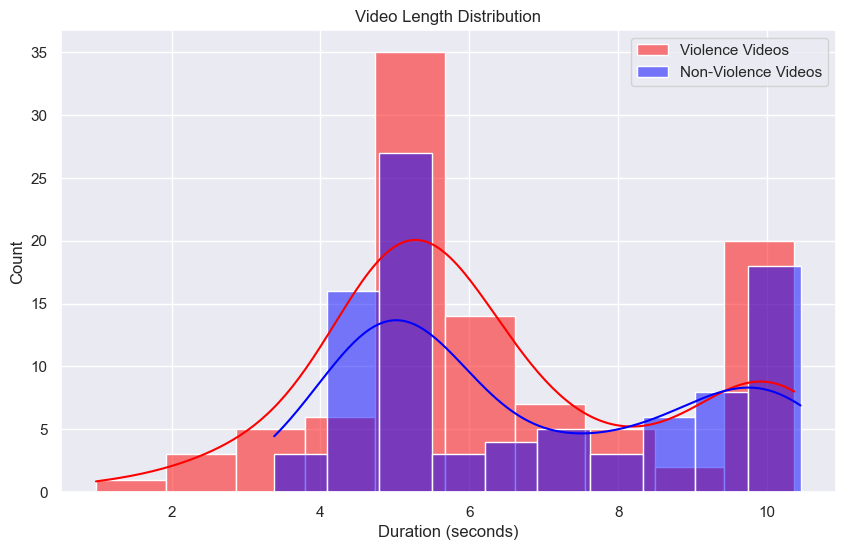

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(violence_durations, color='red', label='Violence Videos', kde=True, bins=10)
sns.histplot(non_violence_durations, color='blue', label='Non-Violence Videos', kde=True, bins=10)
plt.title('Video Length Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.legend()
plt.show()

## Analyze frame extraction consistency

In [8]:
def analyze_frame_extraction(data_path, num_frames=NUM_FRAMES):
    extracted_frames_counts = []
    
    for video_name in os.listdir(data_path):
        video_path = os.path.join(data_path, video_name)
        frames = preprocess_video(video_path, num_frames=num_frames)
        if frames is not None:
            extracted_frames_counts.append(frames.shape[0])
            
    return extracted_frames_counts

In [9]:
violence_frames = analyze_frame_extraction(violence_path)
non_violence_frames = analyze_frame_extraction(non_violence_path)

Error: Not enough frames extracted. Check video file.
Error: Not enough frames extracted. Check video file.


## Plotting frame extraction analysis

In [10]:
print(violence_frames)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


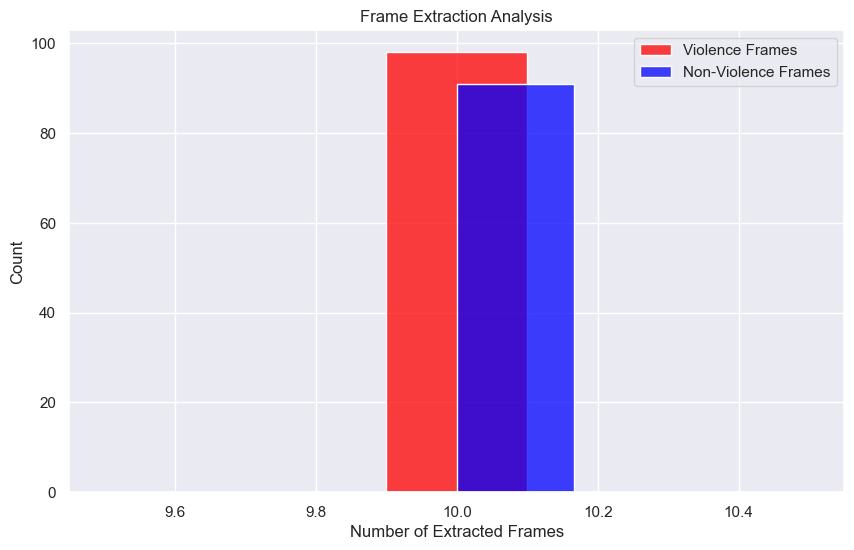

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(violence_frames, color='red', label='Violence Frames', bins=5)
sns.histplot(non_violence_frames, color='blue', label='Non-Violence Frames', bins=6)
plt.title('Frame Extraction Analysis')
plt.xlabel('Number of Extracted Frames')
plt.ylabel('Count')
plt.legend()
plt.show()

# Data Preprocessing

In [12]:
def load_data(data_path, label):
    data = []
    labels = []
    for video_name in os.listdir(data_path):
        video_path = os.path.join(data_path, video_name)
        frames = preprocess_video(video_path)
        if frames is not None:
            data.append(frames)
            labels.append(label)
            
    return np.array(data), np.array(labels)

In [13]:
train_violence_data, train_violence_labels = load_data(r"C:\Users\ASUS\Desktop\Projects\Violence Detectin\costom-videos-dataset 2\costom-videos-dataset\train\violence", label=1)
train_non_violence_data, train_non_violence_labels = load_data(r"C:\Users\ASUS\Desktop\Projects\Violence Detectin\costom-videos-dataset 2\costom-videos-dataset\train\non-violence", label=0)

Error: Not enough frames extracted. Check video file.
Error: Not enough frames extracted. Check video file.


In [14]:
test_violence_data, test_violence_labels = load_data(r"C:\Users\ASUS\Desktop\Projects\Violence Detectin\costom-videos-dataset 2\costom-videos-dataset\test\violence", label=1)
test_non_violence_data, test_non_violence_labels = load_data(r"C:\Users\ASUS\Desktop\Projects\Violence Detectin\costom-videos-dataset 2\costom-videos-dataset\test\non-violence", label=0)

In [15]:
X_train = np.concatenate((train_violence_data, train_non_violence_data), axis=0)
y_train = np.concatenate((train_violence_labels, train_non_violence_labels), axis=0)

In [16]:
X_test = np.concatenate((test_violence_data, test_non_violence_data), axis=0)
y_test = np.concatenate((test_violence_labels, test_non_violence_labels), axis=0)

In [17]:
X_train = X_train.reshape(-1, NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)

# Building Neural Network

In [18]:
model = Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=(NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling3D((2, 2, 2)),
    
    Conv3D(64, (3, 3, 3), activation='relu'),
    MaxPooling3D((2, 2, 2)),
    
    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=False),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(X_train,
          y_train,
          epochs=15,
          batch_size=8,
          verbose=1)

Epoch 1/15
24/24 [==============================] - 8s 38ms/step - loss: 0.7145 - accuracy: 0.4762
Epoch 2/15
24/24 [==============================] - 1s 35ms/step - loss: 0.6888 - accuracy: 0.4974
Epoch 3/15
24/24 [==============================] - 1s 36ms/step - loss: 0.6829 - accuracy: 0.5767
Epoch 4/15
24/24 [==============================] - 1s 36ms/step - loss: 0.6747 - accuracy: 0.5291
Epoch 5/15
24/24 [==============================] - 1s 36ms/step - loss: 0.6353 - accuracy: 0.6190
Epoch 6/15
24/24 [==============================] - 1s 36ms/step - loss: 0.6115 - accuracy: 0.6720
Epoch 7/15
24/24 [==============================] - 1s 35ms/step - loss: 0.6080 - accuracy: 0.6561
Epoch 8/15
24/24 [==============================] - 1s 35ms/step - loss: 0.5543 - accuracy: 0.7302
Epoch 9/15
24/24 [==============================] - 1s 36ms/step - loss: 0.5313 - accuracy: 0.7884
Epoch 10/15
24/24 [==============================] - 1s 36ms/step - loss: 0.4621 - accuracy: 0.8042
Epoch 11/

In [20]:
# model.save("violence_detection_model.h5")

In [21]:
from tensorflow.keras.models import load_model

model = load_model("violence_detection_model.h5")

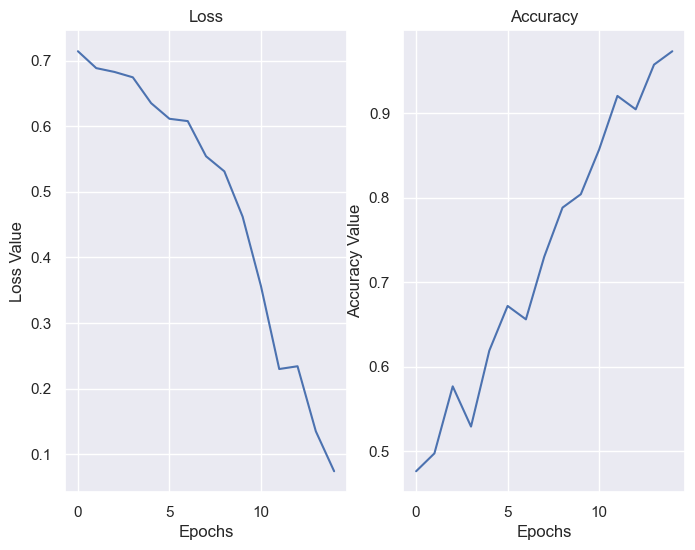

In [34]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')

plt.show()